# Word embeddings 101

Word vectors represent a group of techniques that gained prominence with the introduction of Word2Vec. These methods assign an n-dimensional vector (typically, n ranges from 50 to 300, and for our purposes, it will be a specific value within this range) to each word in a given language.

In this session, we'll start by exploring ConceptNet Numberbatch, a set of word vectors known for their superior performance and reduced propensity to reflect human biases. While delving into the creation of these word vectors might be a bit too advanced for our current scope, we recommend a two-part blog post for those interested in a thorough introduction. https://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/

Our agenda includes the following key topics:

- Maximizing the benefits of this notebook,
- Calculating distances between word vectors,
- The linear structure of word vectors and the concept of subtraction,
- Performing reverse lookups,
- The application of word vectors in solving analogies,
- Visualizing word vectors through Principal Component Analysis (PCA).

In [ ]:
!wget https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-en-17.06.txt.gz

Uncompress the data using gzip

In [2]:
!gzip -d numberbatch-en-17.06.txt.gz

Now let's load the data

In [3]:
# Load our libraries
import pandas as pd
import numpy as np

# Load word vectors
words = pd.read_csv(
    'numberbatch-en-17.06.txt',
    sep=" ",
    index_col=0,
    header=None,
    skiprows=[0]
).transpose()

In [4]:
words

,##,###,####,#####,#####_metres,#####ish,####_adapter,####_form,####_ish,####_metres,...,⠧_⠎,⠨_⠴,⠭_⠋,⠭_⠎,⠽_⠗,⠽_⠗_⠋,形容動詞,形容詞,李,인
1,-0.0264,-0.0096,-0.0364,-0.0322,-0.0633,0.0408,-0.0311,0.0263,-0.0222,0.0120,...,-0.0260,-0.0922,0.0371,0.0241,0.0591,0.0584,-0.0532,-0.0532,-0.0825,-0.1633
2,0.0468,0.0318,0.0254,-0.0619,-0.0772,-0.0174,-0.0403,-0.0786,-0.0266,0.0121,...,-0.0354,-0.1200,-0.0075,-0.0100,0.0319,0.0273,-0.1060,-0.1060,-0.0578,-0.2578
3,-0.0099,-0.0095,-0.0448,-0.0742,-0.1488,-0.1162,-0.1117,-0.1316,-0.1564,-0.0202,...,-0.2038,-0.2133,-0.0978,-0.1075,-0.1338,-0.1340,-0.1399,-0.1399,-0.0945,-0.1895
4,-0.0242,-0.0420,-0.0327,0.0355,0.0472,-0.0440,-0.0828,-0.0781,-0.0659,-0.0377,...,0.0725,0.1314,0.0017,0.0048,0.1210,0.1161,-0.1423,-0.1423,0.0680,0.1788
5,-0.0762,-0.0831,-0.0712,0.0211,-0.1084,-0.0777,-0.0941,-0.0050,-0.0228,-0.1128,...,0.0395,0.0146,0.0362,0.0118,0.0143,0.0259,0.1371,0.1371,-0.0124,0.0823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,-0.0236,0.0028,-0.0543,-0.0684,0.0376,-0.0446,-0.0476,0.0166,0.0004,0.0584,...,-0.0448,-0.0292,-0.0827,-0.0830,-0.0598,-0.0519,-0.0166,-0.0166,0.0280,0.0463
297,-0.0570,-0.0692,-0.0560,0.0229,0.0793,-0.0366,-0.0620,-0.0194,-0.0210,0.0859,...,0.0340,-0.0153,-0.0343,-0.0170,0.0524,0.0756,-0.0262,-0.0262,-0.0213,-0.0887
298,-0.0772,0.0705,0.0353,-0.0023,0.0279,0.0051,0.0336,-0.0151,0.0275,0.0182,...,-0.0762,-0.1173,-0.0238,-0.0188,-0.1003,-0.1172,0.0131,0.0131,-0.0389,0.0544
299,-0.0370,0.0775,-0.0050,0.0950,-0.0201,0.0643,0.0316,0.0780,0.0117,-0.0073,...,0.0529,-0.0138,-0.0064,-0.0008,0.0767,0.0737,0.0174,0.0174,0.0073,0.0397


Display the vector for the work "house"

In [5]:
print(words['house'])

1      0.0331
2      0.1253
3      0.0865
4      0.0641
5     -0.1315
        ...  
296   -0.0046
297   -0.0053
298    0.0449
299   -0.0277
300   -0.0500
Name: house, Length: 300, dtype: float64


### Compute the distances

In our exploration of 'manipulation primitives,' a crucial skill is the ability to measure the distances between vectors corresponding to words. We'll begin by crafting a code snippet for this purpose, with numpy simplifying the process significantly. It's important to note that shorter distances between word vectors signify greater similarity between the words. To illustrate this concept, we'll develop a piece of code that accepts three words and determines whether the first word is more similar (i.e., closer in vector space) to the second word than to the third.

In [6]:
# define the distance between two words
def dist(w1,w2) :
    return np.linalg.norm(words[w1] - words[w2])

# Say if w1 is closer to w2 than w3
def distCompare(w1, w2, w3) :
    d2 = dist(w1,w2)
    d3 = dist(w1,w3)
    if d2 < d3 :
        print("{} is closer to {} than {}".format(w1,w2,w3))
    else :
        print("{} is closer to {} than {}".format(w1,w3,w2))

In [7]:
distCompare('orb','ball','hockey')
distCompare('picked','lifted','play')
distCompare('pink','red','blue')

orb is closer to ball than hockey
picked is closer to lifted than play
pink is closer to red than blue


This observation largely aligns with our expectations. Should you probe further, you'll encounter instances that might defy your predictions—for example, the assertion that 'maroon' is more akin to 'blue' than to 'red'. However, generally speaking, the principle that words sharing similarities tend to cluster nearby each other holds true.

### Display and plot embeddings

Now display the values for the words "red" and "blue"

In [12]:
words['red']

1      0.0212
2     -0.0006
3      0.2265
4      0.0870
5     -0.0108
        ...  
296   -0.0174
297    0.0013
298    0.0497
299   -0.0372
300   -0.0086
Name: red, Length: 300, dtype: float64

In [13]:
words['blue']

1      0.0295
2     -0.0118
3      0.2131
4      0.0820
5     -0.0368
        ...  
296   -0.0696
297   -0.0303
298   -0.0303
299   -0.0493
300    0.0079
Name: blue, Length: 300, dtype: float64

Make a plot for both embeddings


In [14]:
import matplotlib.pyplot as plt

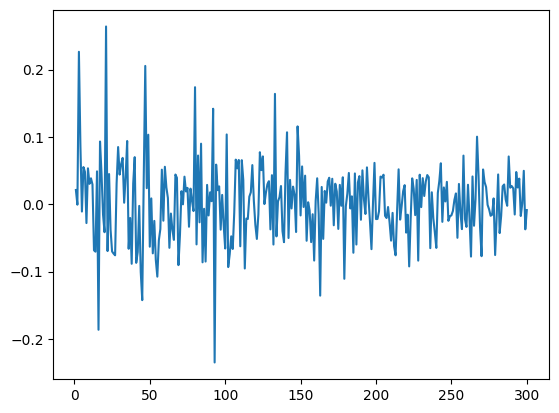

In [15]:
plt.plot(words['red'])

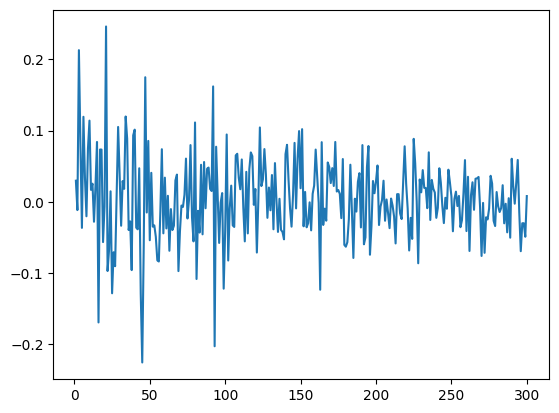

In [16]:
plt.plot(words['blue'])

Make a plot for house

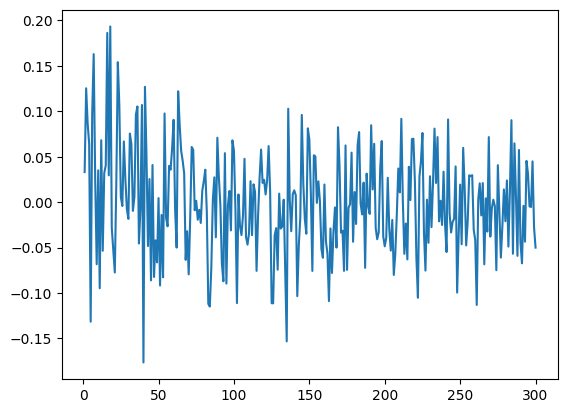

In [17]:
plt.plot(words['house'])

The fascination with word vectors extends far beyond their ability to place similar words in close proximity; it stems from their nuanced and intricate grasp of word meanings. Unpacking the depth of this understanding will require time, but a key concept to embrace is the idea that "relationships equal directions." This means that words sharing a common relationship will consistently diverge from each other in a specific direction.

Our exploration of this concept is facilitated by vector subtraction, a process that might seem straightforward at a glance:

`diff = v - w`

Make the difference between the word red and the word blue

In [18]:
words['red'] - words['blue']

1     -0.0083
2      0.0112
3      0.0134
4      0.0050
5      0.0260
        ...  
296    0.0522
297    0.0316
298    0.0800
299    0.0121
300   -0.0165
Length: 300, dtype: float64

And now plot the result

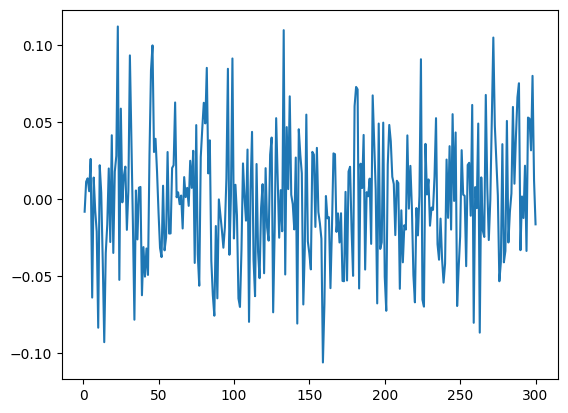

In [19]:
plt.plot(words['red'] - words['blue'])

### Reverse lookup

Exploring the intricate details of word vectors will be made possible through reverse lookup. Specifically, we're set to develop a reverse lookup function that identifies the words closest to a particular vector. Given that a straightforward approach (iterating through each word) would be inefficient, we're introducing a numpy-based solution that will meet our speed requirements

In [20]:
# drop things containing underscores (these are compound terms like "young_man" that our code will not use) and convert to matrix format for faster computation
labels  = words.columns.values.tolist()
labels = np.array([w for w in labels if isinstance(w,str) and w.isalpha()])
wordsMatrix = words[labels].values

# snipped to find the closest word (or vector)
def find_closest_word(v, k = 1):
    if type(v) == type('str'):
        v = words[v]
    diff = wordsMatrix - v.values.reshape(-1,1)
    delta = np.linalg.norm(diff, axis=0)
    return labels[np.argsort(delta)[:k]]

# test with the 50 closest words to blue
print(find_closest_word('blue', 50))

['blue' 'bluecurls' 'bluishness' 'bluer' 'unblue' 'bluest' 'blueish'
 'cyanol' 'bluely' 'gridelin' 'iridovirus' 'ceruleous' 'roygbiv'
 'cyanophore' 'lazuline' 'berylline' 'acyanopia' 'bluing' 'blueness'
 'chromostereopsis' 'umangite' 'red' 'yellowred' 'bluet' 'bluetit'
 'purple' 'yellow' 'kumst' 'cerulean' 'purpre' 'mauvette' 'bepurple'
 'bluish' 'purpureal' 'pyrrh' 'deredden' 'indigoidine' 'zaffre' 'argb'
 'bloncket' 'turquoisey' 'puniceous' 'luteo' 'rubiform' 'xanthous'
 'xanthochromic' 'crustaceorubin' 'tetronerythrin' 'vitellorubin'
 'cyanophyll']


### Small application

Imagine we have four related word vectors: vman, vwoman, vboy, and vgirl. Embracing the notion that "relationships equate to directions," we can understand these relationships as vector equations. The transition from vman to vwoman should mirror the transition from vboy to vgirl, illustrating that vector subtraction reveals the direction of these relationships, expressed as:

vwoman - vman = vgirl - vboy.

Now, if we're faced with an analogy like man:woman::boy:?, aiming to discover the missing term, we can manipulate the formula above by adding vboy to each side, resulting in:

v = vwoman - vman + vboy.

In searching for the answer to our analogy, the target word should be the one whose vector is nearest to the calculated value of vwoman - vman + vboy.

Implement now the analogy function solve this.

This function is taking 3 words in parameters and find the closest word to `word1 - word2 + word3`

In [21]:
# A little snippet for analogies
def analogy(w1,w2,w3, k = 1) :
    listPoss = find_closest_word(words[w2] - words[w1] + words[w3], k)
    print("{} : {} :: {} : {}".format(w1,w2,w3,listPoss))

In [22]:
# A few examples
analogy('man','woman','boy', 2)
analogy('short','tall','shortest', 2)
analogy('seattle','washington','minneapolis', 2)

man : woman :: boy : ['girl' 'boy']
short : tall :: shortest : ['tallest' 'tall']
seattle : washington :: minneapolis : ['minnesota' 'minneapolis']


### Visualization

We'll now implement a final key feature: the capability to automatically illustrate the behavior of a set of vectors by projecting them onto the most suitable pair of axes. For this task, we'll employ the sklearn library.

- Fetch the vectors for the input word list
- Apply the PCA to reduce dimensions
- Then plot the results

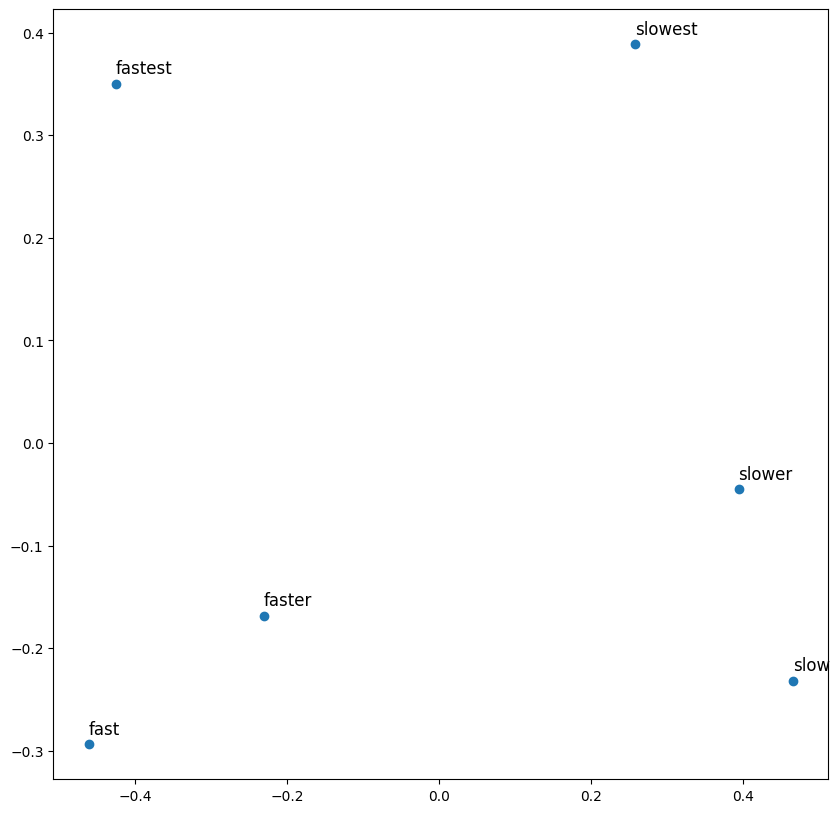

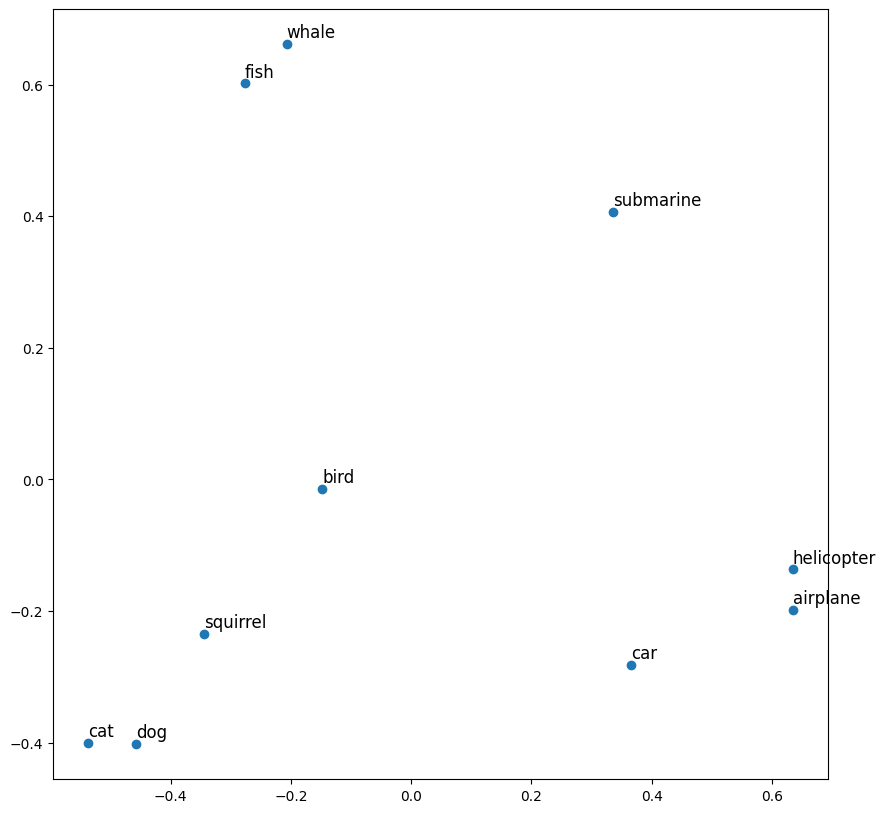

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def pcaPlot(word_list) :
    # fetch list of word vectors
    vecs = [words[x] for x in word_list]

    #reduce dimensions
    model = PCA(n_components = 2)
    reduced = model.fit_transform(vecs)
    xc = [v[0] for v in reduced]
    yc = [v[1] for v in reduced]

    # plot them
    plt.figure(figsize=(10,10))
    plt.scatter(xc, yc)

    # label the plot
    for i, word in enumerate(word_list) :
    	plt.annotate(word, xy=(xc[i], yc[i]+0.01), fontsize=12)
    plt.show()

pcaPlot(['fast','faster','fastest','slow','slower','slowest'])
pcaPlot(['bird', 'cat', 'squirrel', 'dog', 'fish', 'helicopter', 'airplane', 'car', 'submarine', 'whale'])